
# VES inversion for a blocky model

## PyGIMLI

This notebook uses the [pyGIMLI](https://www.pygimli.org/) library for geophysical modelling and inversion. Check out the [pyGIMLI documentation](https://www.pygimli.org/) for installation instructions and further tutorials and examples.


## Introduction

This tutorial shows how an built-in forward operator is used for inversion.
A DC 1D (VES) modelling is used to invert meassured data them.



We import numpy, matplotlib, pandas, pygimli and the VESmanager



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pygimli as pg
from pygimli.physics import VESManager

Here we use data measured at a real site (at Bausenberg in the Eifel, Germany).

- ab2 is the half current electrode spacing $ab/2$.
- rhoa is the apparent resistivity $\rho_a$ (Ohm.m), calculated from measured resistances $R$ and geometry factor $K$ as $\rho_a = R \times K$.
- err is the estimated error of apparent resistivity values (here 2% of $\rho_a$ for most values and 5% for the values at larger $ab/2$).
- mn2 is the potential electrode spacing $mn/2$ (here fixed to 0.5 m).

Replace these data with your own measurements to perform a VES inversion for your site of interest.

In [ ]:
# use data from Bausenberg
ab2 = [1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.5, 10.0, 12.5, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 75.0, 100.]
rhoa = [64.0, 70., 77., 89., 103., 115., 152., 179., 206., 244., 305., 360., 410., 489., 540., 588., 672., 605., 535., 433., 283.]
err = np.ones(len(rhoa))*0.03
err[-4:] = 0.07
mn2 = np.ones(len(rhoa))*0.5

In [21]:
# Create a table with ab2, rhoa, and err
data_table = pd.DataFrame({
    'AB/2 (m)': ab2,
    'ρₐ (Ωm)': rhoa,
    'δρₐ (Ωm)': rhoa*err,
    'Error (%)': err*100
})

print(data_table.round(2).to_string(index=False))

 AB/2 (m)  ρₐ (Ωm)  δρₐ (Ωm)  Error (%)
     1.00     64.0      1.92        3.0
     1.25     70.0      2.10        3.0
     1.50     77.0      2.31        3.0
     2.00     89.0      2.67        3.0
     2.50    103.0      3.09        3.0
     3.00    115.0      3.45        3.0
     4.00    152.0      4.56        3.0
     5.00    179.0      5.37        3.0
     6.00    206.0      6.18        3.0
     7.50    244.0      7.32        3.0
    10.00    305.0      9.15        3.0
    12.50    360.0     10.80        3.0
    15.00    410.0     12.30        3.0
    20.00    489.0     14.67        3.0
    25.00    540.0     16.20        3.0
    30.00    588.0     17.64        3.0
    40.00    672.0     20.16        3.0
    50.00    605.0     42.35        7.0
    60.00    535.0     37.45        7.0
    75.00    433.0     30.31        7.0
   100.00    283.0     19.81        7.0


set up VES manager and perform inversion, you can change the number of layers `nlay` as desired.

Finally, we print a table with the data used for inversion.

In [40]:
nlay=3
ves = VESManager()
result =ves.invert(rhoa, err, ab2=ab2, mn2=mn2, nLayers=nlay,
           lam=1000, lambdaFactor=0.8, cType=2, verbose=False)

In [48]:
data_table_result = pd.DataFrame({
    'Layer': np.arange(1, nlay+1),
    'Thickness (m)': list(result[0:nlay-1]) + [np.inf],
    'Resistivity (Ωm)': result[nlay-1:nlay*2-1]
})
data_table_result['Resistivity (Ωm)'] = data_table_result['Resistivity (Ωm)'].round(0).astype(int)
data_table_result['Thickness (m)'] = data_table_result['Thickness (m)'].round(2).replace({np.inf: '∞'})
print(data_table_result.to_string(index=False))

 Layer Thickness (m)  Resistivity (Ωm)
     1           1.4                62
     2         31.49               945
     3             ∞                61


show estimated & synthetic models and data with model response in 2 subplots



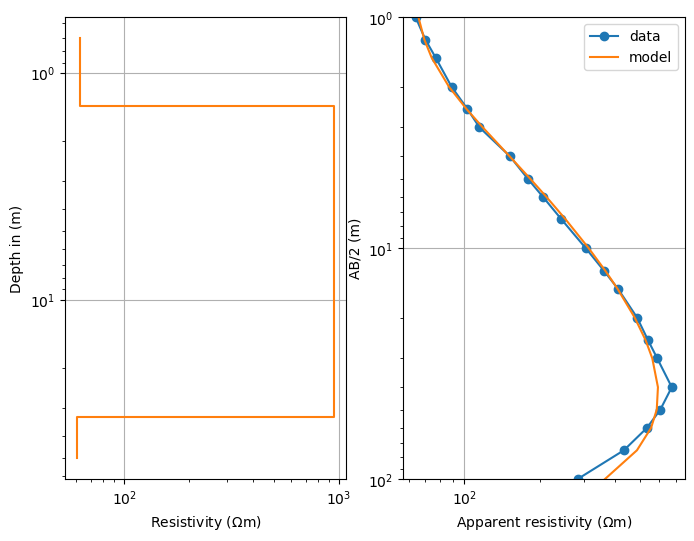

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
#ves.showModel(synthModel, ax=ax[0], label="synth", plot="semilogy", zmax=20)
ves.showModel(ves.model, ax=ax[0], label="model", zmax=50, color="C1")
ax[0].invert_yaxis()
ves.showData(rhoa, ax=ax[1], label="data", color="C0", marker="o")
out = ves.showData(ves.inv.response, ax=ax[1], label="model", color="C1")

Calculate the model covariances and plot it. This can be usesful to assess the uncertainty of the inversion result.

20/11/25 - 12:29:37 - pyGIMLi - INFO - [0.04565188 1.26457602 0.02521144 0.06352483 3.10585657]


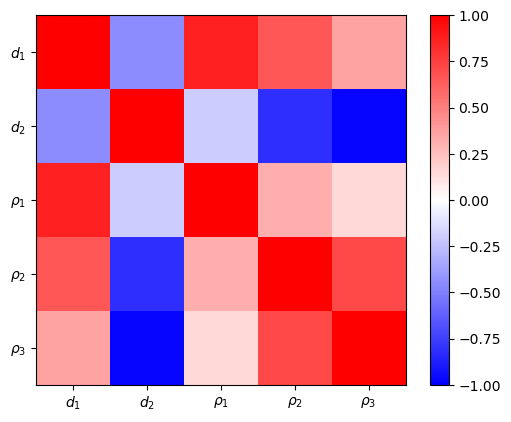

In [57]:
from pygimli.frameworks.resolution import modelCovariance
var, MCM = modelCovariance(ves.inv)
pg.info(var)
fig, ax = plt.subplots()
im = ax.imshow(MCM, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
labels = [rf'$d_{i+1}$' for i in range(nlay-1)] + \
    [rf'$\rho_{i+1}$' for i in range(nlay)]
plt.xticks(np.arange(nlay*2-1), labels)
_ = plt.yticks(np.arange(nlay*2-1), labels)

The model covariance matrix delivers variances and a scaled (dimensionless)
correlation matrix. The latter show the interdependency of the parameters
among each other. The first and last resistivity is best resolved, also the
first layer thickness. The remaining resistivities and thicknesses are highly
correlated. The variances can be used as error bars in the model plot.



<ErrorbarContainer object of 3 artists>

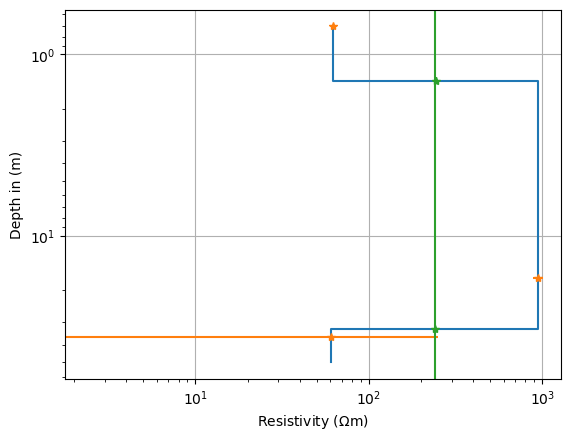

In [58]:
thk = ves.model[:nlay-1]
res = ves.model[nlay-1:]
z = np.cumsum(thk)
mid = np.hstack([z - thk/2, z[-1]*1.1])
resmean = np.sqrt(res[:-1]*res[1:])
fig, ax = plt.subplots()
#ves.showModel(synthModel, ax=ax, label="synth", plot="semilogy", zmax=20)
ves.showModel(ves.model, ax=ax, label="model", zmax=50)
ax.invert_yaxis()
ax.errorbar(res, mid, marker="*", ls="None", xerr=res*var[nlay-1:])
ax.errorbar(resmean, z, marker="*", ls="None", yerr=thk*var[:nlay-1])

In [63]:
# Create uncertainty table
uncertainty_table = pd.DataFrame({
    'Layer': np.arange(1, nlay+1),
    'Resistivity (Ωm)': np.round(res, 0).astype(int),
    'Res. Uncertainty (Ωm)': np.round(res*var[nlay-1:], 0).astype(int),
    'Thickness (m)': list(np.round(thk, 2)) + [np.inf],
    'Thk. Uncertainty (m)': list(np.round(thk*var[:nlay-1], 2)) + [np.nan]
})
uncertainty_table = uncertainty_table.replace({np.inf: '∞', np.nan: '-'})
print(uncertainty_table.to_string(index=False))

 Layer  Resistivity (Ωm)  Res. Uncertainty (Ωm) Thickness (m) Thk. Uncertainty (m)
     1                62                      2           1.4                 0.06
     2               945                     60         31.49                39.82
     3                61                    188             ∞                    -
